# Imports

In [43]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point
import numpy as np
import mercantile

import ee

import rasterio
from rasterio.transform import xy

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import xgboost as xgb



In [5]:
ea_embeddings_path = "../../unsynced-data/embeddings/rwanda-burundi-congo-2021-256.tif"
wa_embeddings_path = "../../unsynced-data/embeddings/benin-2021-256.tif"

# Read in Embeddings Rasters

In [3]:
def raster_to_geodataframe(raster_path):
    """
    Convert a multi-band raster to a GeoDataFrame where:
    - Each row represents a pixel
    - Each column represents a band
    - Geometry column contains the center point of each pixel
    """
    
    with rasterio.open(raster_path) as src:
        # Read all bands
        data = src.read()  # Shape: (bands, height, width)
        transform = src.transform
        crs = src.crs
        
        # Get dimensions
        n_bands, height, width = data.shape
        
        # Create arrays for row and column indices
        rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
        
        # Flatten the arrays
        rows_flat = rows.flatten()
        cols_flat = cols.flatten()
        
        # Convert pixel coordinates to geographic coordinates
        x_coords, y_coords = xy(transform, rows_flat, cols_flat)
        
        # Create Point geometries for each pixel center
        geometries = [Point(x, y) for x, y in zip(x_coords, y_coords)]
        
        # Reshape band data to have pixels as rows and bands as columns
        # data shape: (bands, height, width) -> (height*width, bands)
        pixel_data = data.reshape(n_bands, -1).T
        
        # Create column names for bands
        band_columns = [f'band_{i+1}' for i in range(n_bands)]
        
        # Create DataFrame with band data
        df = pd.DataFrame(pixel_data, columns=band_columns)
        
        # Add coordinate columns (optional, useful for reference)
        df['x'] = x_coords
        df['y'] = y_coords
        df['row'] = rows_flat
        df['col'] = cols_flat
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=geometries, crs=crs)
        
        return gdf

In [6]:
ea_embeddings = raster_to_geodataframe(ea_embeddings_path)

In [ ]:
wa_embeddings = raster_to_geodataframe(wa_embeddings_path)


# Joining RWI data

In [9]:
rwi_path = "../../unsynced-data/rwi-apr2021/"
# read all files in the directory
files = [f for f in os.listdir(rwi_path) if f.endswith('.csv')]
# create a list of dataframes
dataframes = []
for file in files:
    df = pd.read_csv(os.path.join(rwi_path, file))
    dataframes.append(df)
# concatenate all dataframes
rwi_df = pd.concat(dataframes, ignore_index=True)

In [13]:
def quadkey_to_polygon(quadkey):
    quadkey_str = str(quadkey)
    tile = mercantile.quadkey_to_tile(quadkey_str)
    bounds = mercantile.bounds(tile)
    polygon = box(bounds.west, bounds.south, bounds.east, bounds.north)
    return polygon

# convert the quadkey column to a polygon column
rwi_df['geometry'] = rwi_df['quadkey'].apply(quadkey_to_polygon)

# convert the dataframe to a geodataframe
rwi_gdf = gpd.GeoDataFrame(rwi_df, geometry='geometry', crs='EPSG:4326')

In [ ]:
rwi_gdf = rwi_gdf.to_crs(epsg=3857)
wa_embeddings = wa_embeddings.to_crs(epsg=3857)
ea_embeddings = ea_embeddings.to_crs(epsg=3857)

In [18]:
wa_data = wa_embeddings.sjoin_nearest(rwi_gdf, how='left')
ea_data = ea_embeddings.sjoin_nearest(rwi_gdf, how='left')

In [19]:
wa_data = wa_data.to_crs(epsg=4326)
ea_data = ea_data.to_crs(epsg=4326)

In [21]:
wa_data = wa_data.drop(columns=['x', 'y', 'row', 'col', 'index_right'])
ea_data = ea_data.drop(columns=['x', 'y', 'row', 'col', 'index_right'])
wa_data = wa_data.dropna(subset=[col for col in wa_data.columns if col.startswith('band_')])
ea_data = ea_data.dropna(subset=[col for col in ea_data.columns if col.startswith('band_')])

# Data Overview

In [ ]:
wa_data.describe()

band_1         band_2         band_3         band_4  \
count  418882.000000  418882.000000  418882.000000  418882.000000   
mean        0.127323       0.132537      -0.020664       0.003223   
std         0.056174       0.094056       0.069864       0.048367   
min        -0.051028      -0.210730      -0.240899      -0.177025   
25%         0.105518       0.111705      -0.065562      -0.032139   
50%         0.133850       0.155842      -0.020982       0.002302   
75%         0.161253       0.190439       0.025175       0.037864   
max         0.313808       0.320769       0.233009       0.203375   

              band_5         band_6         band_7         band_8  \
count  418882.000000  418882.000000  418882.000000  418882.000000   
mean        0.169403       0.048091      -0.054473       0.081697   
std         0.060906       0.075525       0.067974       0.053771   
min        -0.109815      -0.207809      -0.308136      -0.201294   
25%         0.129332       0.002890      -0.089211       0.049786   
50%         0.170617       0.057057      -0.044712       0.086559   
75%         0.213444       0.101356      -0.008427       0.116595   
max         0.348097       0.284073       0.191301       0.328466   

              band_9        band_10  ...        band_60        band_61  \
count  418882.000000  418882.000000  ...  418882.000000  418882.000000   
mean        0.081522      -0.053198  ...       0.018810      -0.031912   
std         0.050751       0.082507  ...       0.064275       0.051429   
min        -0.222547      -0.275978  ...      -0.269765      -0.274562   
25%         0.046718      -0.119712  ...      -0.025251      -0.065294   
50%         0.077656      -0.054986  ...       0.022004      -0.033283   
75%         0.114309       0.014194  ...       0.063998       0.002229   
max         0.280546       0.223838  ...       0.254738       0.197696   

             band_62        band_63        band_64       quadkey  \
count  418882.000000  418882.000000  418882.000000  4.188820e+05   
mean       -0.123226       0.025888      -0.224505  3.001010e+13   
std         0.064252       0.066688       0.129073  5.409835e+06   
min        -0.348490      -0.251766      -0.464440  3.001010e+13   
25%        -0.169574      -0.015826      -0.293468  3.001010e+13   
50%        -0.127623       0.024108      -0.257207  3.001010e+13   
75%        -0.084505       0.066552      -0.214554  3.001010e+13   
max         0.228799       0.311833       0.214133  3.001012e+13   

            latitude      longitude            rwi          error  
count  418882.000000  418882.000000  418882.000000  418882.000000  
mean       -2.225559      29.211645      -0.102819       0.350458  
std         0.429295       0.425166       0.339910       0.053420  
min        -3.019841      28.443603      -1.060000       0.240000  
25%        -2.602864      28.839111      -0.322000       0.315000  
50%        -2.229662      29.212647      -0.144000       0.357000  
75%        -1.856365      29.586182       0.052000       0.372000  
max        -1.439058      29.937744       1.844000       0.643000  

[8 rows x 69 columns]

In [23]:
ea_data.describe()

band_1         band_2         band_3         band_4  \
count  418882.000000  418882.000000  418882.000000  418882.000000   
mean        0.127323       0.132537      -0.020664       0.003223   
std         0.056174       0.094056       0.069864       0.048367   
min        -0.051028      -0.210730      -0.240899      -0.177025   
25%         0.105518       0.111705      -0.065562      -0.032139   
50%         0.133850       0.155842      -0.020982       0.002302   
75%         0.161253       0.190439       0.025175       0.037864   
max         0.313808       0.320769       0.233009       0.203375   

              band_5         band_6         band_7         band_8  \
count  418882.000000  418882.000000  418882.000000  418882.000000   
mean        0.169403       0.048091      -0.054473       0.081697   
std         0.060906       0.075525       0.067974       0.053771   
min        -0.109815      -0.207809      -0.308136      -0.201294   
25%         0.129332       0.002890      -0.089211       0.049786   
50%         0.170617       0.057057      -0.044712       0.086559   
75%         0.213444       0.101356      -0.008427       0.116595   
max         0.348097       0.284073       0.191301       0.328466   

              band_9        band_10  ...        band_60        band_61  \
count  418882.000000  418882.000000  ...  418882.000000  418882.000000   
mean        0.081522      -0.053198  ...       0.018810      -0.031912   
std         0.050751       0.082507  ...       0.064275       0.051429   
min        -0.222547      -0.275978  ...      -0.269765      -0.274562   
25%         0.046718      -0.119712  ...      -0.025251      -0.065294   
50%         0.077656      -0.054986  ...       0.022004      -0.033283   
75%         0.114309       0.014194  ...       0.063998       0.002229   
max         0.280546       0.223838  ...       0.254738       0.197696   

             band_62        band_63        band_64       quadkey  \
count  418882.000000  418882.000000  418882.000000  4.188820e+05   
mean       -0.123226       0.025888      -0.224505  3.001010e+13   
std         0.064252       0.066688       0.129073  5.409835e+06   
min        -0.348490      -0.251766      -0.464440  3.001010e+13   
25%        -0.169574      -0.015826      -0.293468  3.001010e+13   
50%        -0.127623       0.024108      -0.257207  3.001010e+13   
75%        -0.084505       0.066552      -0.214554  3.001010e+13   
max         0.228799       0.311833       0.214133  3.001012e+13   

            latitude      longitude            rwi          error  
count  418882.000000  418882.000000  418882.000000  418882.000000  
mean       -2.225559      29.211645      -0.102819       0.350458  
std         0.429295       0.425166       0.339910       0.053420  
min        -3.019841      28.443603      -1.060000       0.240000  
25%        -2.602864      28.839111      -0.322000       0.315000  
50%        -2.229662      29.212647      -0.144000       0.357000  
75%        -1.856365      29.586182       0.052000       0.372000  
max        -1.439058      29.937744       1.844000       0.643000  

[8 rows x 69 columns]

In [24]:
wa_data

band_1    band_2    band_3    band_4    band_5    band_6    band_7  \
353     0.014205 -0.034709  0.251965  0.044140 -0.129298  0.024606 -0.040273   
354     0.014137 -0.002215  0.258666  0.045916 -0.129295  0.037978 -0.012157   
355     0.015748 -0.003470  0.257750  0.057116 -0.124567  0.035433 -0.000637   
356    -0.000399 -0.005528  0.271227  0.046929 -0.141302  0.018514 -0.018293   
357     0.012506 -0.021853  0.246105  0.048662 -0.138106  0.004466 -0.020660   
...          ...       ...       ...       ...       ...       ...       ...   
420873  0.041107 -0.060045  0.164892  0.017273 -0.102644 -0.112940 -0.082570   
420874  0.045129 -0.052350  0.163236 -0.002600 -0.127654 -0.144696 -0.111204   
420875  0.060115 -0.004656  0.155919  0.022983 -0.111279 -0.124569 -0.126722   
420876  0.082869  0.020885  0.170722 -0.011520 -0.123154 -0.096673 -0.123938   
420877  0.084288  0.035684  0.209577 -0.032082 -0.125556 -0.088898 -0.105320   

          band_8    band_9   band_10  ...   band_61   band_62   band_63  \
353     0.075344 -0.101997 -0.100285  ... -0.092838  0.037683  0.096177   
354     0.085668 -0.092827 -0.106943  ... -0.112928  0.019644  0.070470   
355     0.083474 -0.099456 -0.091428  ... -0.116226  0.027845  0.073089   
356     0.077118 -0.084214 -0.108152  ... -0.129760  0.023119  0.083842   
357     0.074829 -0.084214 -0.100987  ... -0.131599  0.040821  0.090635   
...          ...       ...       ...  ...       ...       ...       ...   
420873  0.141730 -0.057057 -0.103802  ... -0.205320 -0.039435  0.075356   
420874  0.206956 -0.049971 -0.086507  ... -0.172819 -0.093754  0.093564   
420875  0.211620 -0.048903 -0.067219  ... -0.172178 -0.122390  0.109190   
420876  0.149459 -0.068211 -0.088265  ... -0.212171 -0.092055  0.067077   
420877  0.133216 -0.084240 -0.109538  ... -0.232799 -0.066009  0.055915   

         band_64                  geometry         quadkey   latitude  \
353     0.190057  POINT (2.31464 10.37504)  12222001301201  10.390571   
354     0.200962  POINT (2.31693 10.37504)  12222001301201  10.390571   
355     0.201778  POINT (2.31923 10.37504)  12222001301201  10.390571   
356     0.202693  POINT (2.32153 10.37504)  12222001301201  10.390571   
357     0.192910  POINT (2.32383 10.37504)  12222001301201  10.390571   
...          ...                       ...             ...        ...   
420873  0.199862   POINT (2.26864 8.89174)  12222003303022   8.852507   
420874  0.153813   POINT (2.27094 8.89174)  12222003303022   8.852507   
420875  0.157991   POINT (2.27324 8.89174)  12222003303022   8.852507   
420876  0.164751   POINT (2.27554 8.89174)  12222003303022   8.852507   
420877  0.120343   POINT (2.27784 8.89174)  12222003303022   8.852507   

        longitude    rwi  error  
353      2.318115 -0.707  0.302  
354      2.318115 -0.707  0.302  
355      2.318115 -0.707  0.302  
356      2.318115 -0.707  0.302  
357      2.318115 -0.707  0.302  
...           ...    ...    ...  
420873   2.296143 -0.192  0.324  
420874   2.296143 -0.192  0.324  
420875   2.296143 -0.192  0.324  
420876   2.296143 -0.192  0.324  
420877   2.296143 -0.192  0.324  

[419749 rows x 70 columns]

In [25]:
ea_data

band_1    band_2    band_3    band_4    band_5    band_6    band_7  \
563     0.038447 -0.088827 -0.124567  0.075875  0.098424  0.102813  0.055363   
564     0.043154 -0.084214 -0.127264  0.071111  0.088827  0.103406  0.053482   
565     0.044844 -0.079723 -0.130165  0.066660  0.088827  0.103406  0.055673   
566     0.042617 -0.079723 -0.130165  0.062991  0.088827  0.103406  0.059116   
567     0.034612 -0.078484 -0.135886  0.054333  0.082939  0.104269  0.056428   
...          ...       ...       ...       ...       ...       ...       ...   
414396  0.163792  0.150888 -0.100151 -0.024566  0.179377  0.111288 -0.009782   
414397  0.139871  0.108395 -0.115443  0.056034  0.188606  0.145799 -0.035433   
414398  0.211537  0.100416 -0.110771  0.037559  0.197913  0.142647 -0.003313   
414399  0.192082  0.156382 -0.064490  0.013467  0.186910  0.160000  0.029876   
414400  0.176660  0.148034 -0.033921 -0.022342  0.192910  0.176237  0.016417   

          band_8    band_9   band_10  ...   band_61   band_62   band_63  \
563     0.030103  0.114378  0.018034  ...  0.010396 -0.054931  0.029773   
564     0.011441  0.113741  0.006821  ...  0.009599 -0.053615  0.024758   
565     0.008742  0.113310  0.005185  ...  0.010533 -0.051734  0.022019   
566     0.007443  0.108512  0.007443  ...  0.013276 -0.054213  0.021486   
567     0.014958  0.109996  0.006361  ...  0.008860 -0.049778  0.022888   
...          ...       ...       ...  ...       ...       ...       ...   
414396  0.228275  0.058206 -0.114646  ... -0.029801 -0.173029  0.025291   
414397  0.221453  0.041558 -0.124567  ... -0.037302 -0.078572  0.070191   
414398  0.186082  0.031024 -0.078264  ...  0.006178 -0.135993  0.117283   
414399  0.186082  0.020803 -0.102993  ...  0.034746 -0.156890  0.084214   
414400  0.154595 -0.033912 -0.121705  ...  0.053423 -0.147483  0.120389   

         band_64                   geometry         quadkey  latitude  \
563     0.123916   POINT (29.7683 -1.47985)  30010103001032 -1.482989   
564     0.121730   POINT (29.7706 -1.47985)  30010103001032 -1.482989   
565     0.119093   POINT (29.7729 -1.47985)  30010103001032 -1.482989   
566     0.115437   POINT (29.7752 -1.47985)  30010103001033 -1.482989   
567     0.122235   POINT (29.7775 -1.47985)  30010103001033 -1.482989   
...          ...                        ...             ...       ...   
414396 -0.279712  POINT (29.17728 -2.96315)  30010120101331 -2.954013   
414397 -0.318893  POINT (29.17958 -2.96315)  30010120101331 -2.954013   
414398 -0.270993  POINT (29.18188 -2.96315)  30010120110220 -2.954013   
414399 -0.229814  POINT (29.18418 -2.96315)  30010120110220 -2.954013   
414400 -0.260327  POINT (29.18648 -2.96315)  30010120110220 -2.954013   

        longitude    rwi  error  
563     29.761963  0.034  0.315  
564     29.761963  0.034  0.315  
565     29.761963  0.034  0.315  
566     29.783935 -0.216  0.314  
567     29.783935 -0.216  0.314  
...           ...    ...    ...  
414396  29.168701 -0.006  0.258  
414397  29.168701 -0.006  0.258  
414398  29.190674 -0.225  0.342  
414399  29.190674 -0.225  0.342  
414400  29.190674 -0.225  0.342  

[418882 rows x 70 columns]

# PCA Exploration

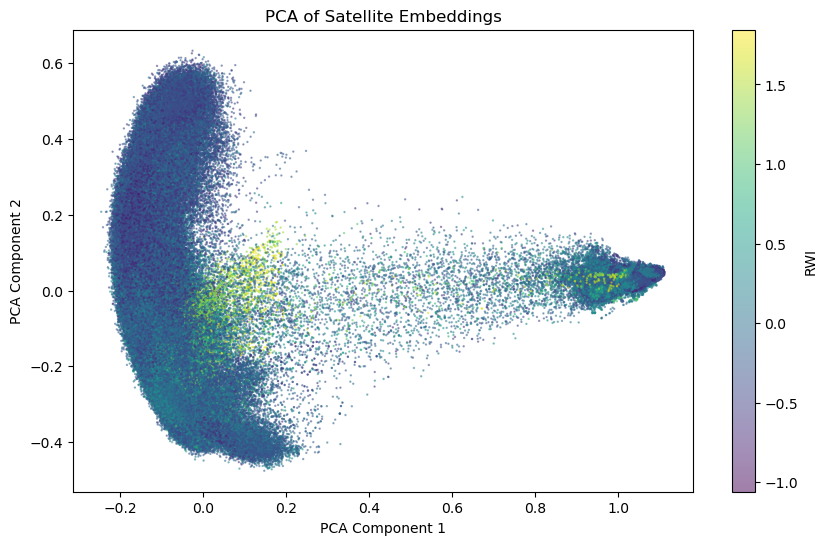

In [ ]:
# not scaling data
band_cols = [col for col in ea_data.columns if col.startswith('band_')]
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(ea_data[band_cols])

# Visualize the result
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=ea_data['rwi'], cmap='viridis', s=0.5)
plt.colorbar(label='RWI')
plt.title('PCA of Satellite Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

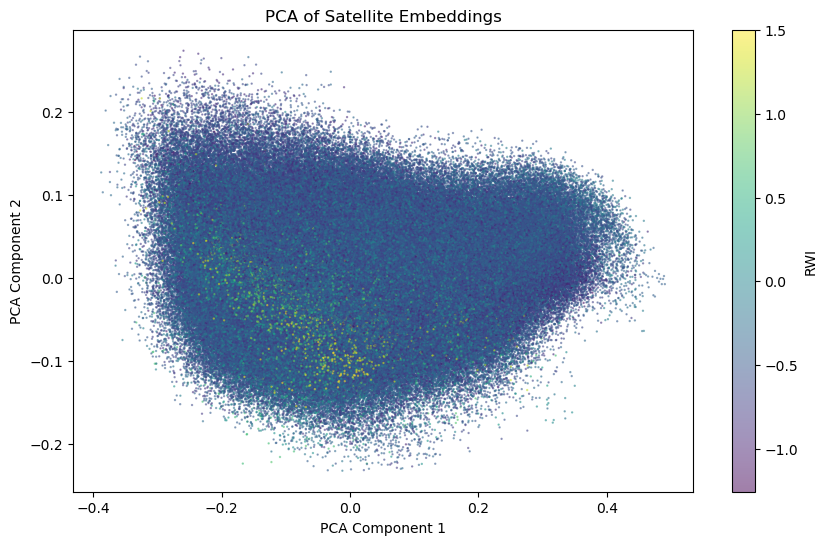

In [29]:
# not scaling data
band_cols = [col for col in wa_data.columns if col.startswith('band_')]
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(wa_data[band_cols])

# Visualize the result
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=wa_data['rwi'], cmap='viridis', s=0.5)
plt.colorbar(label='RWI')
plt.title('PCA of Satellite Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

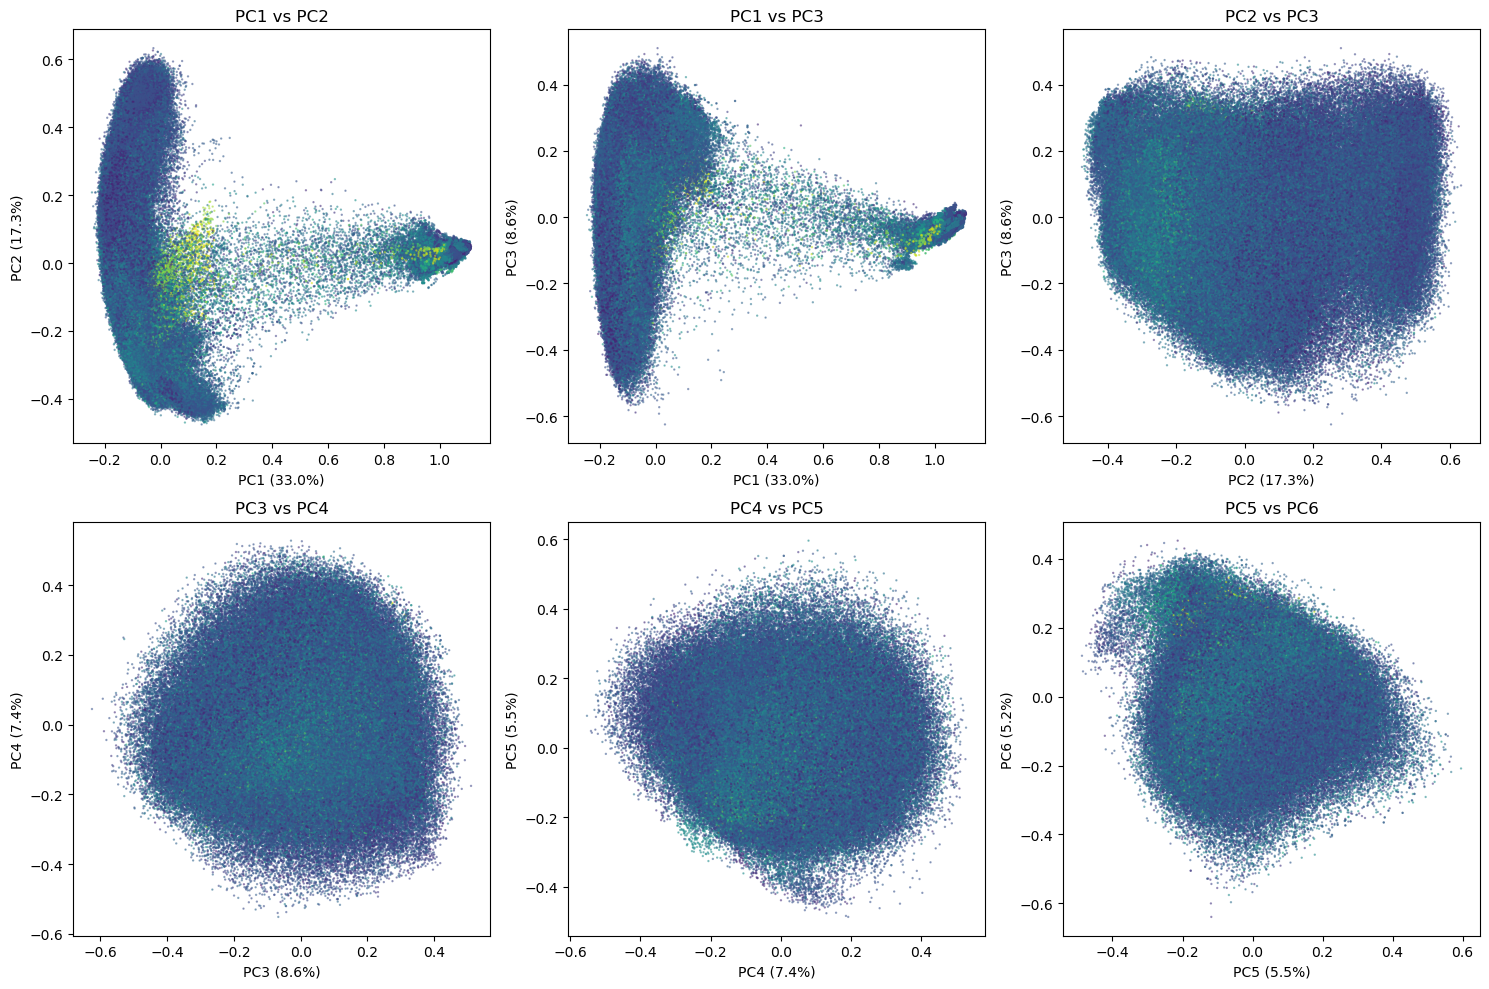

In [39]:
# Fit with more components
pca_multi = PCA(n_components=6)
pca_multi_result = pca_multi.fit_transform(ea_data[band_cols])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

for i, (pc1, pc2) in enumerate(pairs):
    scatter = axes[i].scatter(pca_multi_result[:, pc1], pca_multi_result[:, pc2], 
                             alpha=0.5, c=ea_data['rwi'], 
                             cmap='viridis', s=0.5)
    axes[i].set_xlabel(f'PC{pc1+1} ({pca_multi.explained_variance_ratio_[pc1]:.1%})')
    axes[i].set_ylabel(f'PC{pc2+1} ({pca_multi.explained_variance_ratio_[pc2]:.1%})')
    axes[i].set_title(f'PC{pc1+1} vs PC{pc2+1}')

plt.tight_layout()
plt.show()

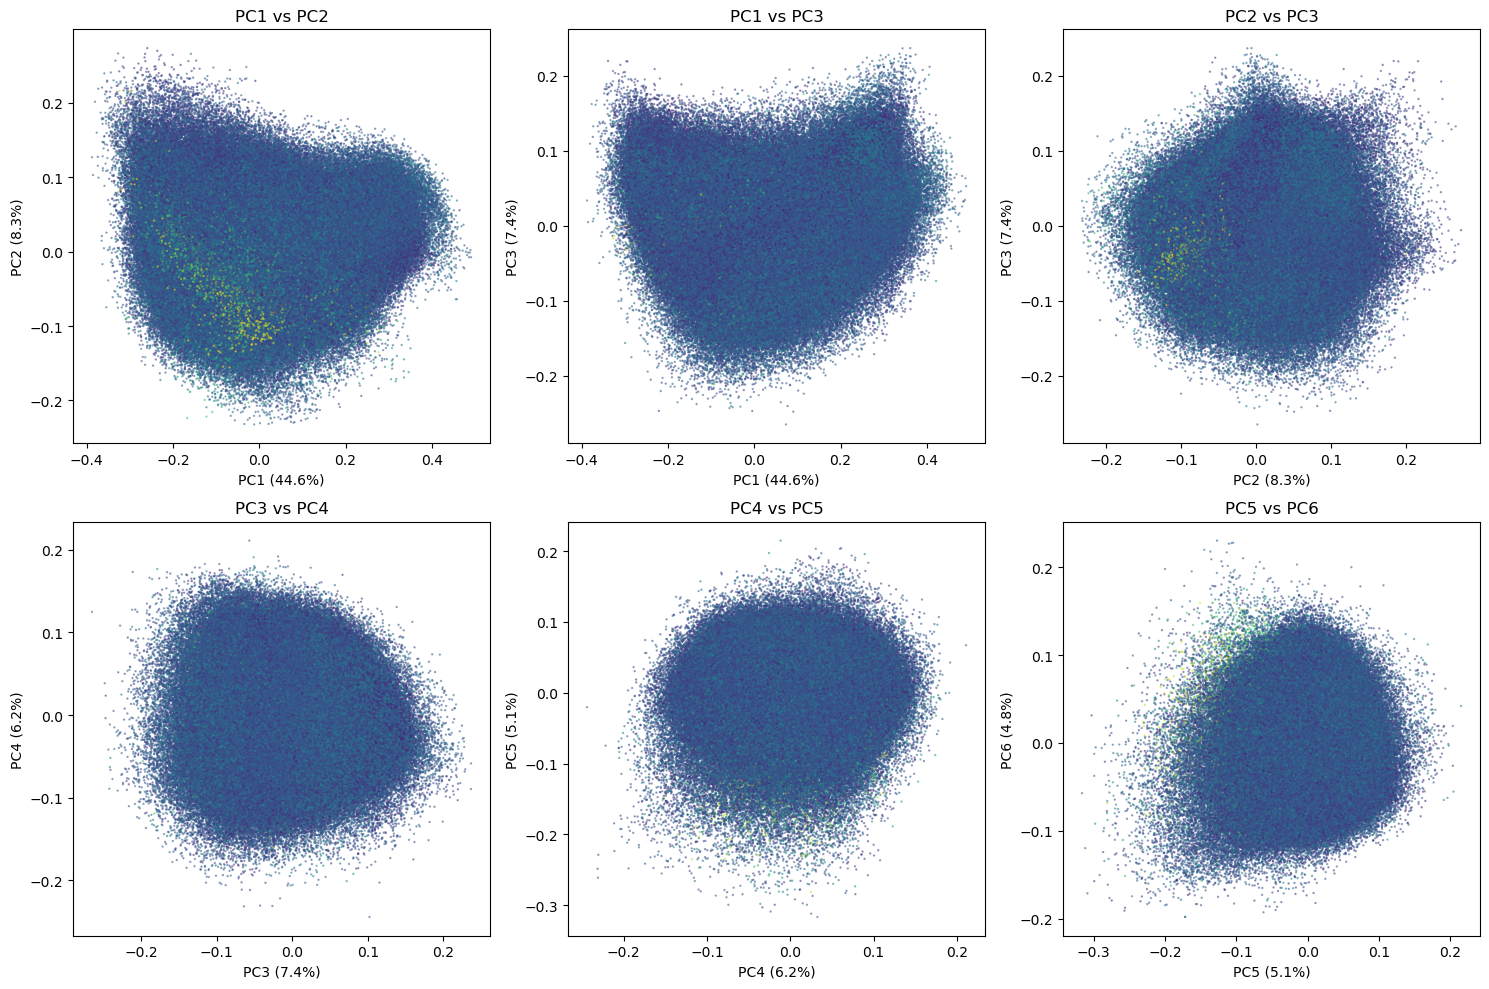

In [40]:
pca_multi_wa = PCA(n_components=6)
pca_multi_result_wa = pca_multi_wa.fit_transform(wa_data[band_cols])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

for i, (pc1, pc2) in enumerate(pairs):
    scatter = axes[i].scatter(pca_multi_result_wa[:, pc1], pca_multi_result_wa[:, pc2], 
                             alpha=0.5, c=wa_data['rwi'], 
                             cmap='viridis', s=0.5)
    axes[i].set_xlabel(f'PC{pc1+1} ({pca_multi_wa.explained_variance_ratio_[pc1]:.1%})')
    axes[i].set_ylabel(f'PC{pc2+1} ({pca_multi_wa.explained_variance_ratio_[pc2]:.1%})')
    axes[i].set_title(f'PC{pc1+1} vs PC{pc2+1}')

plt.tight_layout()
plt.show()

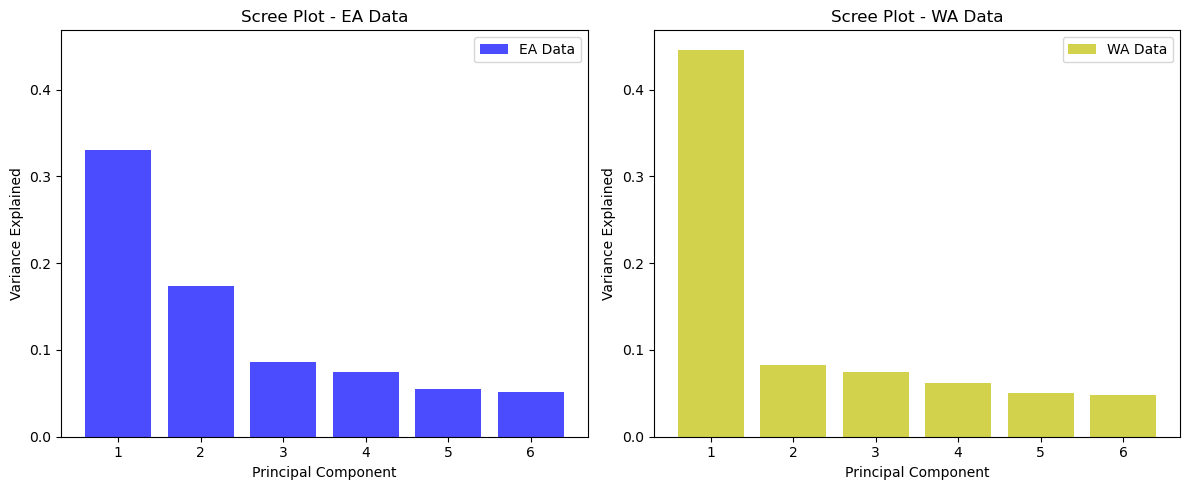

In [42]:
# make scree plots of both
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scree plot for EA data
axes[0].bar(range(1, 7), pca_multi.explained_variance_ratio_, alpha=0.7, color='b', label='EA Data')
axes[0].set_title('Scree Plot - EA Data')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].legend()

# Scree plot for WA data
axes[1].bar(range(1, 7), pca_multi_wa.explained_variance_ratio_, alpha=0.7, color='y', label='WA Data')
axes[1].set_title('Scree Plot - WA Data')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained')
axes[1].legend()

# Set the same y-axis limits for both plots
ymax = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, ymax)
axes[1].set_ylim(0, ymax)

plt.tight_layout()
plt.show()

# XGBoost Experiment

## Train on East Africa Run on West Africa

In [53]:
# Prepare data for XGBoost
X = ea_data[[col for col in ea_data.columns if col.startswith('band_')]]
y = ea_data['rwi']
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y)
# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}
model_100 = xgb.train(params, dtrain, num_boost_round=100)
model_50 = xgb.train(params, dtrain, num_boost_round=50)
model_150 = xgb.train(params, dtrain, num_boost_round=150)
# Make predictions
predictions_100 = model_100.predict(dtrain)
predictions_50 = model_50.predict(dtrain)
predictions_150 = model_150.predict(dtrain)
# Add predictions to the GeoDataFrame
ea_data['predicted_rwi_100'] = predictions_100
ea_data['predicted_rwi_50'] = predictions_50
ea_data['predicted_rwi_150'] = predictions_150

/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:14:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:14:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:15:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [54]:
# evaluate model performance
mse_100 = mean_squared_error(ea_data['rwi'], ea_data['predicted_rwi_100'])
mse_50 = mean_squared_error(ea_data['rwi'], ea_data['predicted_rwi_50'])
mse_150 = mean_squared_error(ea_data['rwi'], ea_data['predicted_rwi_150'])
r2_100 = r2_score(ea_data['rwi'], ea_data['predicted_rwi_100'])
r2_50 = r2_score(ea_data['rwi'], ea_data['predicted_rwi_50'])
r2_150 = r2_score(ea_data['rwi'], ea_data['predicted_rwi_150'])

print ("Trained on East Africa Run on East Africa Performance:")
print(f'MSE (100 rounds): {mse_100}, R2: {r2_100}')
print(f'MSE (50 rounds): {mse_50}, R2: {r2_50}')
print(f'MSE (150 rounds): {mse_150}, R2: {r2_150}')

Trained on East Africa Run on East Africa Performance:
MSE (100 rounds): 0.06802684818563105, R2: 0.4112191063390761
MSE (50 rounds): 0.07257887250036002, R2: 0.3718207656033886
MSE (150 rounds): 0.06518919242301556, R2: 0.4357793724748181


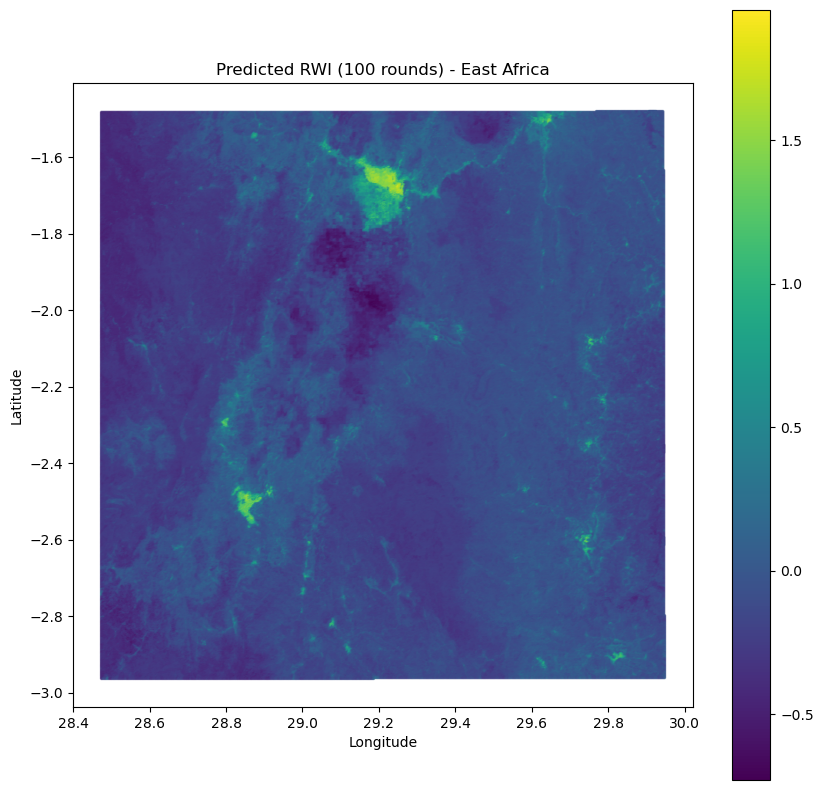

In [55]:
# plot predictions in geographical space
fig, ax = plt.subplots(figsize=(10, 10))
ea_data.plot(column='predicted_rwi_100', ax=ax, legend=True, cmap='viridis', markersize=1, alpha=0.5)
ax.set_title('Predicted RWI (100 rounds) - East Africa')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [47]:
# Run already trained model on West Africa 
X_wa = wa_data[[col for col in wa_data.columns if col.startswith('band_')]]

# Create DMatrix for XGBoost (no labels needed for prediction)
dtest_wa = xgb.DMatrix(X_wa)

# Make predictions using the pre-trained models
predictions_100_wa = model_100.predict(dtest_wa)
predictions_50_wa = model_50.predict(dtest_wa)
predictions_150_wa = model_150.predict(dtest_wa)

# Add predictions to the GeoDataFrame
wa_data['predicted_rwi_100'] = predictions_100_wa
wa_data['predicted_rwi_50'] = predictions_50_wa
wa_data['predicted_rwi_150'] = predictions_150_wa

In [48]:
# evaluate moodel performance
mse_100_wa = mean_squared_error(wa_data['rwi'], wa_data['predicted_rwi_100'])
mse_50_wa = mean_squared_error(wa_data['rwi'], wa_data['predicted_rwi_50'])
mse_150_wa = mean_squared_error(wa_data['rwi'], wa_data['predicted_rwi_150'])
r2_100_wa = r2_score(wa_data['rwi'], wa_data['predicted_rwi_100'])
r2_50_wa = r2_score(wa_data['rwi'], wa_data['predicted_rwi_50'])
r2_150_wa = r2_score(wa_data['rwi'], wa_data['predicted_rwi_150'])

print ("Trained on East Africa Run on West Africa Performance:")
print(f'MSE (100 rounds): {mse_100_wa}, R2: {r2_100_wa}')
print(f'MSE (50 rounds): {mse_50_wa}, R2: {r2_50_wa}')
print(f'MSE (150 rounds): {mse_150_wa}, R2: {r2_150_wa}')

Trained on East Africa Run on West Africa Performance:
MSE (100 rounds): 0.9106879613056155, R2: -12.272694430436113
MSE (50 rounds): 0.824870998807163, R2: -11.021967102760469
MSE (150 rounds): 0.9348896833293329, R2: -12.625419046066956


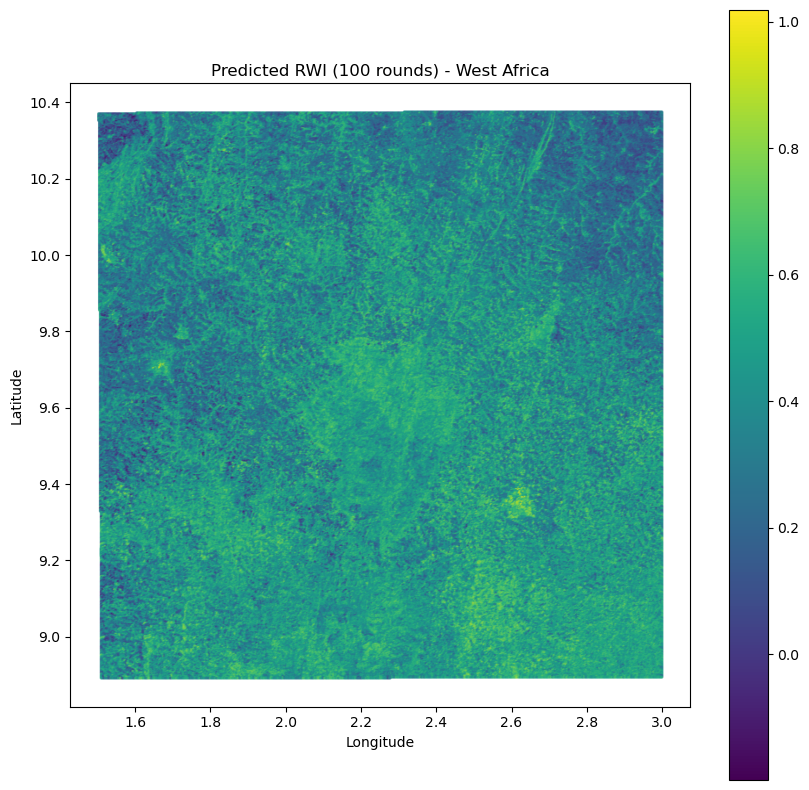

In [56]:
# plot predictions in geographical space
fig, ax = plt.subplots(figsize=(10, 10))
wa_data.plot(column='predicted_rwi_100', ax=ax, legend=True, cmap='viridis', markersize=1, alpha=0.5)
ax.set_title('Predicted RWI (100 rounds) - West Africa')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## Train on West Africa Run on East Africa

In [57]:
# Prepare data for XGBoost
X = wa_data[[col for col in wa_data.columns if col.startswith('band_')]]
y = wa_data['rwi']
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y)
# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}
model_100 = xgb.train(params, dtrain, num_boost_round=100)
model_50 = xgb.train(params, dtrain, num_boost_round=50)
model_150 = xgb.train(params, dtrain, num_boost_round=150)
# Make predictions
predictions_100 = model_100.predict(dtrain)
predictions_50 = model_50.predict(dtrain)
predictions_150 = model_150.predict(dtrain)
# Add predictions to the GeoDataFrame
wa_data['predicted_rwi_100'] = predictions_100
wa_data['predicted_rwi_50'] = predictions_50
wa_data['predicted_rwi_150'] = predictions_150

/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:16:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:16:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/geo_new/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:16:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [60]:
# evaluate model performance
mse_100 = mean_squared_error(wa_data['rwi'], wa_data['predicted_rwi_100'])
mse_50 = mean_squared_error(wa_data['rwi'], wa_data['predicted_rwi_50'])
mse_150 = mean_squared_error(wa_data['rwi'], wa_data['predicted_rwi_150'])
r2_100 = r2_score(wa_data['rwi'], wa_data['predicted_rwi_100'])
r2_50 = r2_score(wa_data['rwi'], wa_data['predicted_rwi_50'])
r2_150 = r2_score(wa_data['rwi'], wa_data['predicted_rwi_150'])
print ("Trained on West Africa Run on East Africa Performance:")
print(f'MSE (100 rounds): {mse_100}, R2: {r2_100}')
print(f'MSE (50 rounds): {mse_50}, R2: {r2_50}')
print(f'MSE (150 rounds): {mse_150}, R2: {r2_150}')

Trained on West Africa Run on East Africa Performance:
MSE (100 rounds): 0.04968176256534805, R2: 0.2759200941341373
MSE (50 rounds): 0.05243938794188127, R2: 0.23572946844071285
MSE (150 rounds): 0.04784302323184855, R2: 0.3027185436005978


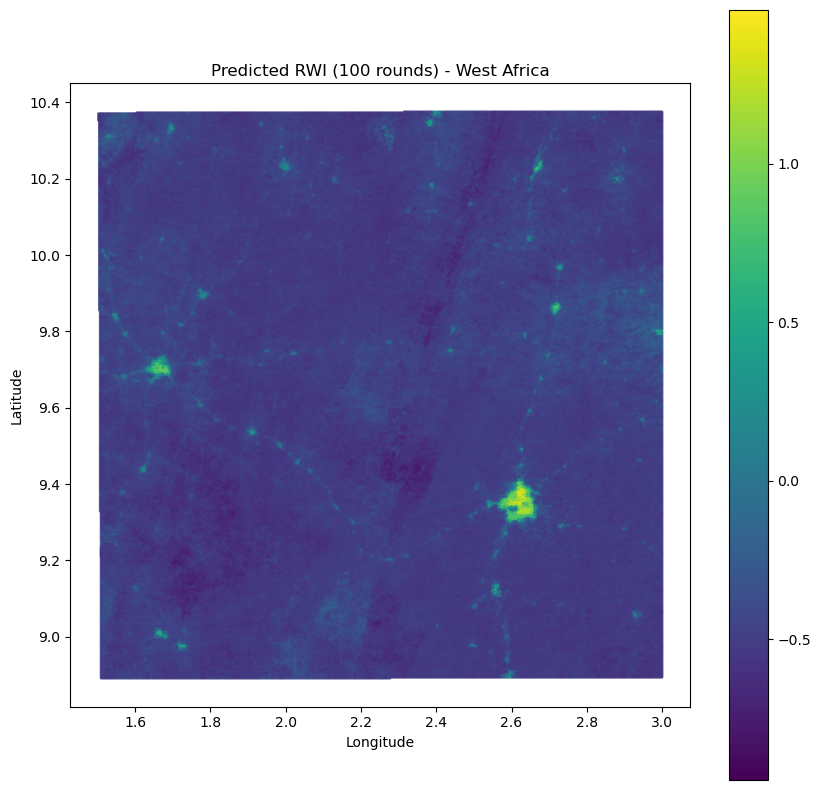

In [62]:
# plot predictions_100 in geographical space
fig, ax = plt.subplots(figsize=(10, 10))
wa_data.plot(column='predicted_rwi_100', ax=ax, legend=True, cmap='viridis', markersize=1, alpha=0.5)
ax.set_title('Predicted RWI (100 rounds) - West Africa')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [ ]:
# Run already trained model on East Africa
X_ea = ea_data[[col for col in ea_data.columns if col.startswith('band_')]]

# Create DMatrix for XGBoost (no labels needed for prediction)
dtest_ea = xgb.DMatrix(X_wa)

# Make predictions using the pre-trained models
predictions_100_ea = model_100.predict(dtest_ea)
predictions_50_ea = model_50.predict(dtest_ea)
predictions_150_ea = model_150.predict(dtest_ea)

# Add predictions to the GeoDataFrame
ea_data['predicted_rwi_100'] = predictions_100_ea
ea_data['predicted_rwi_50'] = predictions_50_ea
ea_data['predicted_rwi_150'] = predictions_150_ea

In [64]:
# evaluate model performance
mse_100 = mean_squared_error(ea_data['rwi'], ea_data['predicted_rwi_100'])
mse_50 = mean_squared_error(ea_data['rwi'], ea_data['predicted_rwi_50'])
mse_150 = mean_squared_error(ea_data['rwi'], ea_data['predicted_rwi_150'])
r2_100 = r2_score(ea_data['rwi'], ea_data['predicted_rwi_100'])
r2_50 = r2_score(ea_data['rwi'], ea_data['predicted_rwi_50'])
r2_150 = r2_score(ea_data['rwi'], ea_data['predicted_rwi_150'])
print ("Trained on West Africa Run on East Africa Performance:")
print(f'MSE (100 rounds): {mse_100}, R2: {r2_100}')
print(f'MSE (50 rounds): {mse_50}, R2: {r2_50}')
print(f'MSE (150 rounds): {mse_150}, R2: {r2_150}')

Trained on West Africa Run on East Africa Performance:
MSE (100 rounds): 0.1308877457051061, R2: -0.13284983709996423
MSE (50 rounds): 0.13770293826243146, R2: -0.19183618251205226
MSE (150 rounds): 0.13475930993624216, R2: -0.16635871056200768


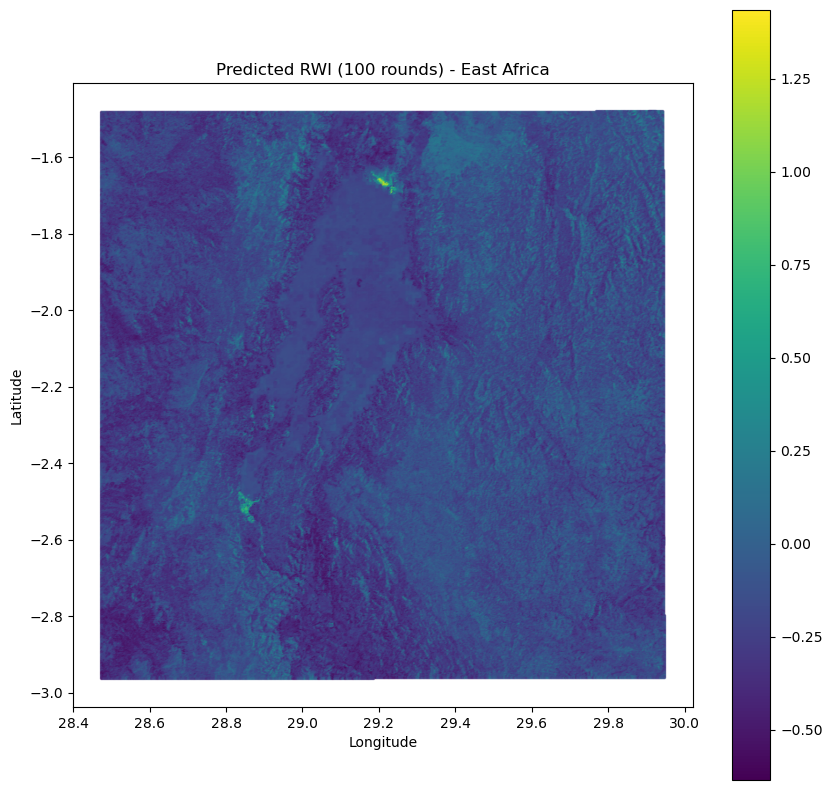

In [65]:
# plot predictions_100 in geographical space
fig, ax = plt.subplots(figsize=(10, 10))
ea_data.plot(column='predicted_rwi_100', ax=ax, legend=True, cmap='viridis', markersize=1, alpha=0.5)
ax.set_title('Predicted RWI (100 rounds) - East Africa')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()